## Investigating problematic voltage setpoints with pypowsybl-jupyter
- This notebook demonstrates how to **investigate faulty voltage setpoints** with the help of the **network explorer widget**.
- It compares **target voltage** and **calculated voltage** on each generator.
- We will visualize differences by providing the widget a **custom styling** to apply on bus nodes.

#### 1. Loading networks
- We load a network snapshot based on the IEEE 300 network.
- We then run an AC loadflow on that snapshot.

In [1]:
import pypowsybl.network as pn
network = pn.create_ieee300()

In [2]:
import pypowsybl.loadflow as lf
lf.run_ac(network)

[ComponentResult(connected_component_num=0, synchronous_component_num=0, status=CONVERGED, status_text=Converged, iteration_count=6, reference_bus_id='VL7049_0', slack_bus_results=[SlackBusResult(id='VL7049_0', active_power_mismatch=455.130606132974)], distributed_active_power=0.0)]

#### 2. Compute voltage differences
- We're constructing the dataframe containing the delta between target_v and calculated v for each generator.
- We're then aggregating that dataframe to have the maximum difference for each bus.

- getting the generators dataframe

In [3]:
gens = network.get_generators(attributes=['target_v', 'bus_id'])
gens

,target_v,bus_id
id,,
B8-G,116.7595,VL8_0
B10-G,234.7150,VL10_0
B20-G,115.1150,VL20_0
B63-G,110.2045,VL63_0
B76-G,110.7680,VL76_0
...,...,...
B9002-G,6.5637,VL9002_0
B9051-G,13.8000,VL9051_0
B9053-G,13.8000,VL9051_2


- getting the buses dataframe

In [4]:
bus_v = network.get_buses(attributes=['v_mag'])
bus_v

,v_mag
id,
VL1_0,118.267059
VL1_1,119.063364
VL3_0,229.327111
VL4_0,355.618836
VL5_0,117.196123
...,...
VL9051_4,13.800000
VL9071_0,0.586742
VL9071_1,0.589698


- constructing the `delta_v` column

In [5]:
gens['delta_v'] = gens['bus_id'].map(bus_v['v_mag']) - gens['target_v']
gens

,target_v,bus_id,delta_v
id,,,
B8-G,116.7595,VL8_0,0.000000
B10-G,234.7150,VL10_0,-0.003737
B20-G,115.1150,VL20_0,-0.005141
B63-G,110.2045,VL63_0,-0.000918
B76-G,110.7680,VL76_0,-0.002259
...,...,...,...
B9002-G,6.5637,VL9002_0,0.000000
B9051-G,13.8000,VL9051_0,0.000000
B9053-G,13.8000,VL9051_2,0.000000


- looking at extreme values

In [6]:
gens['delta_v'].min(), gens['delta_v'].max()

(np.float64(-0.020795146300287115), np.float64(0.0))

In [7]:
gens.sort_values(by='delta_v', key=abs, ascending=False).head(10)

,target_v,bus_id,delta_v
id,,,
B156-G,110.74500,VL156_0,-0.020795
B170-G,106.83500,VL170_0,-0.010452
B20-G,115.11500,VL20_0,-0.005141
B236-G,20.33000,VL236_0,-0.004181
B10-G,234.71500,VL10_0,-0.003737
B171-G,113.03350,VL171_0,-0.002670
B76-G,110.76800,VL76_0,-0.002259
B7055-G,13.75446,VL7055_0,-0.001016
B63-G,110.20450,VL63_0,-0.000918


- Taking the maximum value for each bus to aggregate the values (maximum is taken in absolute value)

In [8]:
bus_max_delta_v = gens.groupby('bus_id')['delta_v'].apply(lambda s: s.iloc[s.abs().values.argmax()]).to_frame()
bus_max_delta_v['v_mag'] = bus_v['v_mag'][bus_max_delta_v.index]
bus_max_delta_v

,delta_v,v_mag
bus_id,,
VL108_0,0.000000,113.850000
VL10_0,-0.003737,234.711263
VL116_1,0.000000,117.679500
VL119_0,0.000000,120.002500
VL125_0,0.000000,116.184500
...,...,...
VL9051_3,0.000000,13.800000
VL9051_4,0.000000,13.800000
VL91_0,0.000000,120.980000


#### 3. Construct a style dataframe
  - Green/Red gradient indicate small/big changes
  - Gray indicate NaN values (buses without generators)

In [9]:
import pandas as pd
import numpy as np

red_value_legend = 0.005

def create_style_gradient(n_colors=100):
    r = np.linspace(91, 255, n_colors)
    g = np.linspace(217, 0, n_colors)
    b = np.linspace(179, 0, n_colors)

    colors = ['#{:02x}{:02x}{:02x}'.format(int(r[i]), int(g[i]), int(b[i])) 
              for i in range(n_colors)]

    numeric_widths = np.linspace(1, 15, n_colors)
    width_strings = [f"{int(width)}px" for width in numeric_widths]

    return pd.DataFrame({
        'width': width_strings,
        'hex_color': colors
    })

style_df = create_style_gradient(100)

def map_index(value):
    if pd.isna(value):
        return -1
    return min(int(abs(value) / red_value_legend * 99), 99)


bus_max_delta_v['dv_idx'] = bus_max_delta_v['delta_v'].apply(map_index)
bus_max_delta_v

,delta_v,v_mag,dv_idx
bus_id,,,
VL108_0,0.000000,113.850000,0
VL10_0,-0.003737,234.711263,73
VL116_1,0.000000,117.679500,0
VL119_0,0.000000,120.002500,0
VL125_0,0.000000,116.184500,0
...,...,...,...
VL9051_3,0.000000,13.800000,0
VL9051_4,0.000000,13.800000,0
VL91_0,0.000000,120.980000,0


#### 4. Construct the custom style profile

- first taking the default style profile

In [10]:
default_pf = network.get_default_nad_profile()

- then overriding the bus nodes styles based on the `delta_v` column and on the style dataframe

In [11]:
color = bus_max_delta_v['dv_idx'].apply(lambda idx: 'gray' if idx == -1 else style_df['hex_color'].iloc[idx])
width = bus_max_delta_v['dv_idx'].apply(lambda idx: '1px' if idx == -1 else style_df['width'].iloc[idx])
bus_nodes_styles_df = pd.DataFrame({
    'fill': color
})
bus_nodes_styles_df.index.name = 'id'
bus_nodes_styles_df

,fill
id,
VL108_0,#5bd9b3
VL10_0,#d3382f
VL116_1,#5bd9b3
VL119_0,#5bd9b3
VL125_0,#5bd9b3
...,...
VL9051_3,#5bd9b3
VL9051_4,#5bd9b3
VL91_0,#5bd9b3


- overriding the bus description to display it only for buses for gener
   - the calculated v
   - the maximum delta_v

In [12]:
bus_descriptions_df = pd.DataFrame({
    'description': bus_max_delta_v['v_mag'].apply(lambda x: f"{x:.3f}kV")
                   + ' / '
                   + bus_max_delta_v['delta_v'].apply(lambda x: f"max delta_v={x*1e3:.1f}V")
})
bus_descriptions_df

,description
id,
VL108_0,113.850kV / max delta_v=0.0V
VL10_0,234.711kV / max delta_v=-3.7V
VL116_1,117.680kV / max delta_v=0.0V
VL119_0,120.003kV / max delta_v=0.0V
VL125_0,116.184kV / max delta_v=0.0V
...,...
VL9051_3,13.800kV / max delta_v=0.0V
VL9051_4,13.800kV / max delta_v=0.0V
VL91_0,120.980kV / max delta_v=0.0V


- remove unneeded branch labels and voltage level descriptions

In [13]:
vl_descriptions_df = default_pf.vl_descriptions[default_pf.vl_descriptions['type'] != 'FOOTER']
labels_df = pd.DataFrame()

- creating the custom NAD style profile

In [14]:
diagram_profile=pn.NadProfile(branch_labels=labels_df, vl_descriptions=vl_descriptions_df, bus_descriptions=bus_descriptions_df,
                                      bus_node_styles=bus_nodes_styles_df, edge_styles=default_pf.edge_styles)

#### 5. Display the results!

##### _Construct a colorbar to display the color legend_

In [15]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Patch

def display_legend(max_value):
    cmap = ListedColormap(style_df["hex_color"].tolist())
    norm = Normalize(vmin=0.0, vmax=max_value)
    
    fig, ax = plt.subplots(figsize=(6, 1.2))
    fig.subplots_adjust(bottom=0.5)
    
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])

    cbar = plt.colorbar(sm, ax=ax, orientation="horizontal", fraction=0.3, pad=0.25)
    cbar.set_label("|delta_v|")

    tick_vals = np.linspace(0, max_value, 5)
    cbar.set_ticks(tick_vals)
    cbar.set_ticklabels([f"{v*1e3:.2f} V" for v in tick_vals])  # convert kV -> V for readability

    ax.axis("off")

    ax.legend(handles=[Patch(facecolor="gray", edgecolor="none", label="NaN / unavailable")],
              loc="upper center", bbox_to_anchor=(0.5, 1.6), ncol=1, frameon=False)

    plt.show()

##### _Display the widget_

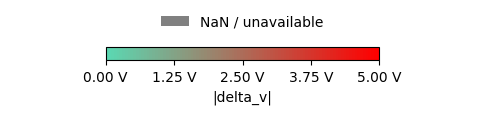

In [16]:
from pypowsybl_jupyter import network_explorer

display_legend(red_value_legend)
network_explorer(network, depth=10, nad_profile=diagram_profile)